# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
import os
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [2]:
# Generater Spike time train using Poisson
# Refering "Poisson Model of Spike Generation" by Heeger (2000); https://www.cns.nyu.edu/~david/handouts/poisson.pdf.
def Spike_Time_Generater(rdt, dt, r_mean, Gamma=1):  
    # rdt: original input (continuous)
    # dt: time bin length of the imput
    # r_mean: target mean firing rate (Hz)
    # Gamma: Gamma tune the spike interval (without changing the probability of spike count);
    #        First increase the target firing rate by Gamma, then only expert every Gamma-th spike.
    rdt = rdt / ( sum(rdt)/(len(rdt)*dt) ) *r_mean *Gamma
                #original mean firing rate
    Spike_time = []
    
    timeBinCounter = 0 # time bin index
    p = 1 # probability of no spike in a bin.

    while True:

        # Use a random number to determine if there is a spike in the bin; if not, accumalate the probability of not firing (lowering "p"). 
        # The while loop stops when a spike appears.
        theRandomNumber = 1-np.random.rand()
        while (theRandomNumber < p and timeBinCounter < len(rdt)): 
            p *= np.exp(-rdt[timeBinCounter]) 
            timeBinCounter += 1
        if timeBinCounter >= len(rdt): # End the funciton when current time exceeds the total time.
            return Spike_time[::Gamma]

        # Resume the exceeding probability (from "theRandomNumber" to "p") into the time unit, 
        # subtract it from the current time to determine the exact firing time and renew "p" with it. 
        remainer_c = -np.log(p/theRandomNumber)/rdt[timeBinCounter-1]
        Spike_time.append(dt*(timeBinCounter-remainer_c))
        p = np.exp(-remainer_c*rdt[timeBinCounter-1]) 

In [3]:
# activation function
def NL(inp, theta = 0):
    y = inp.copy()
    y[y<theta] = theta
    return y-theta

In [4]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [5]:
def MIfunc(r, x, dt, window):
    negshift = window[0] # second
    posshift = window[1] # second
    shiftlen = (posshift-negshift)/dt+1
    timeshift = np.linspace(negshift,posshift,int(shiftlen))
    bitshift = np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16') #time-bin-axis of TLPI;
    MIxr = np.zeros(len(bitshift))

    for i in range(len(bitshift)):
        xx=[]
        rr=[]
        shift=bitshift[i] 
        if shift>0:
            xx=x[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            rr=r
        elif shift<0:
            xx=x[:shift]
            rr=r[(-1*shift):]
        xedges = np.append(np.unique(xx),(max(xx)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        N, _, _ = np.histogram2d(xx, rr, bins=(xedges, redges)) 
        px=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis]
        pr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :]
        pxr=N/np.sum(N)

        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        if shift==0:
            Hr = -np.nansum(pr*np.log2(pr))/dt  
    return timeshift, MIxr, Hr


def MIfunc4ISI(r, x, Spike, dt, window, PorP):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    MIxr = np.zeros(len(bitshift))

    for i in range(len(bitshift)):
        xx=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            rr=r[:(-1*shift)]
            SS=np.hstack((Spike[:sum(rr)+1],Spike[-1]-timeshift[i]))
        elif shift==0:
            xx=x
            rr=r
            SS=Spike
        elif shift<0:
            xx=x[:shift]
            rr=r[(-1*shift):]
            SS=np.hstack((-timeshift[i],Spike[-sum(rr)-1:]))
        if len(SS)-2 != sum(rr):
            print(timeshift[i], SS[0:2], i)
            print(len(SS), sum(rr))
        new_xx = []
        new_vv = []
        post_ISI,_ = EqualState(np.diff(SS)[1:],cut_state_num)
        pre_ISI,_ = EqualState(np.diff(SS)[:-1],cut_state_num)
        for j in np.squeeze(np.where(rr != 0)):
            for k in range(rr[j]):
                new_xx.append(xx[j])
        new_xx = np.array(new_xx)
        if PorP == 'post':
            new_rr = post_ISI
        elif PorP == 'pre':
            new_rr = pre_ISI
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(new_xx),(max(new_xx)+1))
        redges = np.append(np.unique(new_rr),(max(new_rr)+1))
        N, _, _ = np.histogram2d(new_xx, new_rr, bins=(xedges, redges)) 
        px=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis]
        pr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :]
        pxr=N/np.sum(N)

        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt

        if shift==0:
            Hr = -np.nansum(pr*np.log2(pr))/dt
    return timeshift, MIxr, Hr

# Load and Set

## k_E and k_S

In [6]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [7]:
m = 4.037925
n =	100
alpha = 8.351984
beta = 3.123359
g =  442.699730/n
tau_y = 0.050404
# tau_y = 0.001
# gamma,kappa,K,g=1,0.6,22,10

# m = 22
# n =	22
# alpha = 6
# beta = 1.6
# g =  10
# tau_y = 0.05

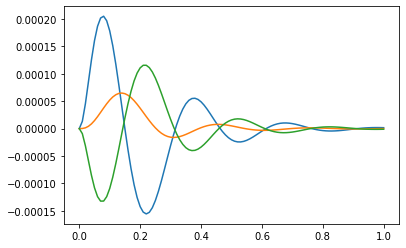

In [8]:
dt = 0.01
TKaxis = np.arange(101)*dt

psi = 0.3
k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)
plt.plot(TKaxis, -(k_E*(1-psi)-k_S*psi))

## LPOU input

In [9]:
tot = 300
Taxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(Taxis))
mu, sigma = 0, 1
for i in range(len(Taxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
LPOU = (LPOU-np.mean(LPOU))/np.std(LPOU)
x = LPOU


global cut_state_num
cut_state_num = 8
xstate = EqualState(LPOU, cut_state_num)[0]

1.2431632612256454


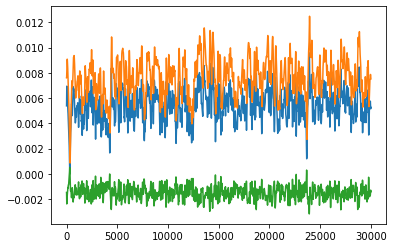

In [10]:
amp = 2
mean = 10

apapt_step = int(1/dt)
eOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*amp+mean)), k_E, 'full')[apapt_step:apapt_step+len(LPOU)]
sOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*amp+mean)), k_S, 'full')[apapt_step:apapt_step+len(LPOU)]
baseOutput = -(eOutput*(1-psi)-sOutput*psi)

print(np.std(sOutput)/np.std(eOutput))
plt.plot(eOutput)
plt.plot(sOutput)
plt.plot(baseOutput)


## Subtraction + GC (Gain act on both)

In [11]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

0.05: 0.631; 0.801
0.1: 0.633; 0.802
0.15: 0.636; 0.802
0.2: 0.64; 0.803
0.3: 0.651; 0.804


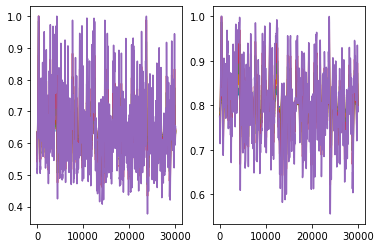

In [12]:
B_e = 3000 #To tune altitude of gain control (D=1/T)
tau_e = 0.1

B_s = 245.0 #To tune altitude of gain control (D=1/T)
tau_s = 0.6

contrast_list = np.array([0.5,1,1.5,2,3])/mean
DCCM_output = [0]*len(contrast_list)
Spike_list = [0]*len(contrast_list)
fig, ax = plt.subplots(1,2)
for i in range(len(contrast_list)):
    eOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*contrast_list[i]*mean+mean)), k_E, 'full')[:apapt_step+len(LPOU)]
    sOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*contrast_list[i]*mean+mean)), k_S, 'full')[:apapt_step+len(LPOU)]
    eOutput, gain_e = AddGainControl(eOutput, B_e, tau_e)    
    ax[0].plot(gain_e[apapt_step:])
    sOutput, gain_s = AddGainControl(sOutput, B_s, tau_s)
    ax[1].plot(gain_s[apapt_step:]) # make sure the value of gain is good
    print(str(round(contrast_list[i], 3))+': '+str(round(np.mean(gain_e),3))+'; '+str(round(np.mean(gain_s),3)))
    DCCM_output[i] = -eOutput[apapt_step:]*(1-psi)+sOutput[apapt_step:]*psi
    Spike_list[i] = Spike_Time_Generater( NL(DCCM_output[i],np.mean(DCCM_output[i])), dt, 10, 10)

# Rate code

In [13]:
rstate_list = [np.histogram(Spike, np.append(Taxis, Taxis[-1]+dt))[0] for Spike in Spike_list]
rateInformation_list = [0]*len(Spike_list)
rateHr_list = [0]*len(Spike_list)
for i in range(len(Spike_list)):
    timeshift, rateInformation_list[i], rateHr_list[i] = MIfunc(rstate_list[i], xstate, dt, [-1,1])

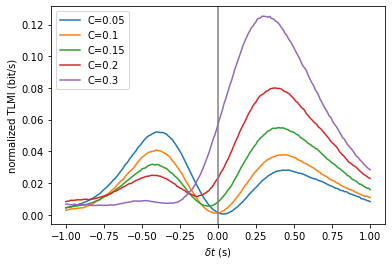

In [14]:
for i in range(len(Spike_list)):
    plt.plot(timeshift,rateInformation_list[i]/rateHr_list[i], label = 'C='+str(round(contrast_list[i],3)))
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Rate code ('Binary-Word')

In [15]:
def binaryState(spikeTrain, wordLength, dt, Ttotal):
    rstate,_ = np.histogram(spikeTrain, np.arange(0,Ttotal+1.5*dt,dt/wordLength))
    rstate[rstate>1] = 1
    rstate = rstate[:wordLength*int(len(rstate)/wordLength)]
    _, index = np.unique(rstate.reshape((-1,wordLength)), axis = 0, return_inverse=True)
    return index

In [16]:
wordLength = 3

wordstate_list = [0]*len(Spike_list)
wordInformation_list = [0]*len(Spike_list)
wordHr_list = [0]*len(Spike_list)
for i in range(len(Spike_list)):
    wordstate_list[i] = binaryState(Spike_list[i], wordLength, dt, Taxis[-1])
    timeshift, wordInformation_list[i], wordHr_list[i] = MIfunc(wordstate_list[i], xstate, dt, [-1,1])

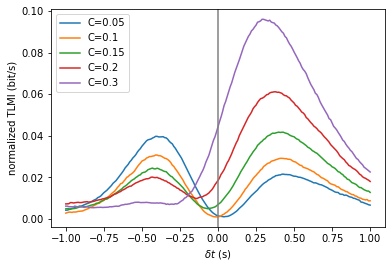

In [17]:
for i in range(len(Spike_list)):
    plt.plot(timeshift,wordInformation_list[i]/wordHr_list[i], label = 'C='+str(round(contrast_list[i],3)))
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Time code (event = bin)

In [18]:
timestate_list = [0]*len(Spike_list)
timeInformation_list = [0]*len(Spike_list)
timeHr_list = [0]*len(Spike_list)
for i in range(len(Spike_list)):
    HeadSpikeEnd = np.hstack((0, Spike_list[i], Taxis[-1]+dt))
    ISI = np.zeros(len(rstate_list[i]))

    counter = 0
    for j in range(len(rstate_list[i])):
        counter += rstate_list[i][j]
        ISI[j] = (HeadSpikeEnd[counter+1]-HeadSpikeEnd[counter-rstate_list[i][j]])/(rstate_list[i][j]+1)
        
    timestate_list[i], _ = EqualState(ISI, cut_state_num)

    timeshift, timeInformation_list[i], timeHr_list[i] = MIfunc(timestate_list[i], xstate, dt, [-1,1])

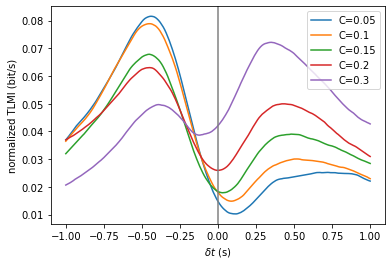

In [19]:
for i in range(len(Spike_list)):
    plt.plot(timeshift,timeInformation_list[i]/timeHr_list[i], label = 'C='+str(round(contrast_list[i],3)))
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Time code (event = spike; pre-ISI)

In [20]:
preInformation_list = [0]*len(Spike_list)
preHr_list = [0]*len(Spike_list)
for i in range(len(Spike_list)):
    HeadSpikeEnd = np.hstack((0, Spike_list[i], Taxis[-1]+dt))
    timeshift, preInformation_list[i], preHr_list[i] = MIfunc4ISI(rstate_list[i], xstate, HeadSpikeEnd, dt, [-1,1], 'pre')

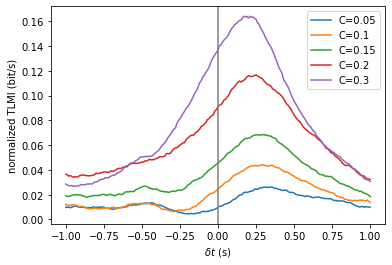

In [21]:
for i in range(len(Spike_list)):
    plt.plot(timeshift,preInformation_list[i]/preHr_list[i], label = 'C='+str(round(contrast_list[i],3)))
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Time code (event = spike; post-ISI)

In [22]:
postInformation_list = [0]*len(Spike_list)
postHr_list = [0]*len(Spike_list)
for i in range(len(Spike_list)):
    HeadSpikeEnd = np.hstack((0, Spike_list[i], Taxis[-1]+dt))
    timeshift, postInformation_list[i], postHr_list[i] = MIfunc4ISI(rstate_list[i], xstate, HeadSpikeEnd, dt, [-1,1], 'post')

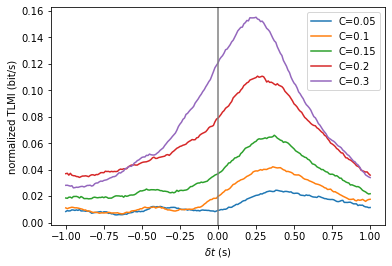

In [23]:
for i in range(len(Spike_list)):
    plt.plot(timeshift,postInformation_list[i]/postHr_list[i], label = 'C='+str(round(contrast_list[i],3)))
plt.xlabel(r'$\delta t$ (s)')
plt.ylabel('normalized TLMI (bit/s)')
plt.axvline(0, c = 'gray')
plt.legend( loc='best')

# Comparasion

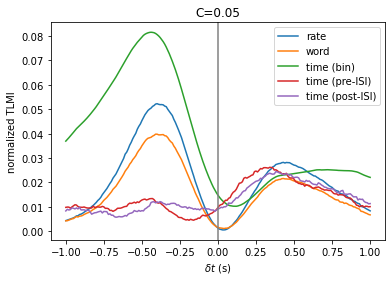

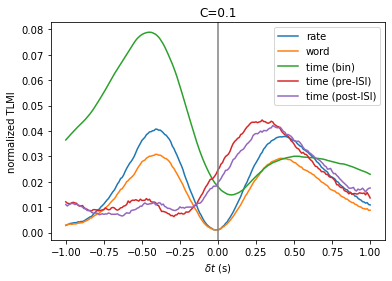

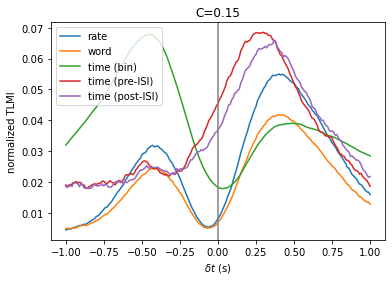

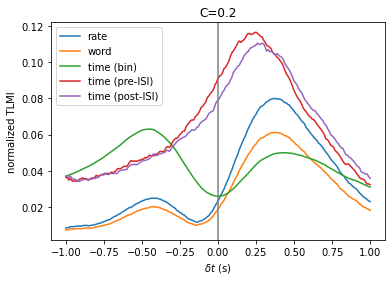

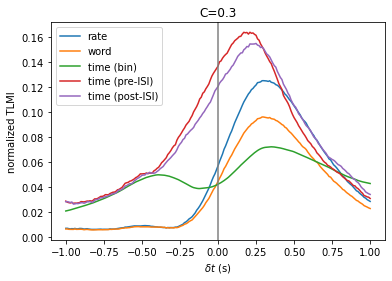

In [24]:
for i in range(len(Spike_list)):
    plt.plot(timeshift, rateInformation_list[i]/rateHr_list[i], label='rate')
    plt.plot(timeshift, wordInformation_list[i]/wordHr_list[i], label='word')
    plt.plot(timeshift, timeInformation_list[i]/timeHr_list[i], label='time (bin)')
    plt.plot(timeshift, preInformation_list[i]/preHr_list[i]  , label='time (pre-ISI)')
    plt.plot(timeshift, postInformation_list[i]/postHr_list[i], label='time (post-ISI)')
    plt.title('C='+str(round(contrast_list[i],3)))
    plt.xlabel(r'$\delta t$ (s)')
    plt.ylabel('normalized TLMI')
    plt.axvline(0, c = 'gray')
    plt.legend( loc='best')
    plt.show()